# Week 3: Fast pipelines, profiling
While implementing a deep learning pipeline, you might encounter bottlenecks in different parts of your solution: from loading data from disk to model execution. In this seminar, we will try to highlight the key points in DL pipelines to pay attention to.

### Seminar outline
1. Faster training
    - Automatic mixed precision (AMP)
    - Tensor cores on GPU
2. Profiling
    - General purpose Python profiling with `py-spy`
    - Deep learning profiling: PyTorch profiler
    - Memory profiling
    - Profiling with nsight systems
    - Extra. Deep learning profiling: PyTorch profiler with TensorBoard
    - Extra. Profiling with `nvprof`
    - Extra. `torch.utils.bottleneck`
3. Data loading from disk: image decoders benchmarks
4. Data augmentations on GPU: Nvidia DALI
5. Data loading to GPU: efficient batching for LM

## 0. Before we start

In [26]:
#!pip install -r requirements.txt
#!nvidia-smi

## 1. Faster training
### Automatic mixed precision (AMP)
Let's use a simple MNIST training example to see the difference between full precision training, half precision training and mixed precision training.

In [1]:
import torch
import torch.nn as nn
import torchvision

device = torch.device("cuda:0")

In [2]:
# very standard data things
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

mnist_train = torchvision.datasets.MNIST(
    "./mnist/", train=True, download=True, transform=transform
)
mnist_val = torchvision.datasets.MNIST(
    "./mnist/", train=False, download=True, transform=transform
)

train_dataloader = torch.utils.data.DataLoader(
    mnist_train, batch_size=1024, shuffle=True
)
val_dataloader = torch.utils.data.DataLoader(
    mnist_val, batch_size=1024, shuffle=False
)

In [3]:
from train import model_provider, train, train_amp

Firstly, let's check that full precision training converges to a reasonable accuracy score.

In [4]:
model = model_provider()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss = nn.CrossEntropyLoss()

train(model, loss, optimizer, train_dataloader, val_dataloader, n_epochs=1)

Epoch 0:   0%|          | 0/59 [00:00<?, ?it/s]

Starting validation...
Epoch: 0, loss: 0.23850038647651672, accuracy: 0.9215760231018066


Now, let's try to cast both the model and the data to half precision. Training process diverges because of the division on overflowed values in Adam.

In [ ]:
model = model_provider()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss = nn.CrossEntropyLoss()

train(model, loss, optimizer, train_dataloader, val_dataloader, precision="half", n_epochs=1)

Epoch 0:   0%|          | 0/59 [00:00<?, ?it/s]

Starting validation...
Epoch: 0, loss: nan, accuracy: 0.09818439185619354


In [7]:
print("Master parameters dtype: {}".format(optimizer.param_groups[0]["params"][0][0].dtype))
print("Optimizer first moment dtype: {}".format(optimizer.state_dict()["state"][0]["exp_avg"].dtype))
print("Optimizer second moment dtype: {}".format(optimizer.state_dict()["state"][0]["exp_avg_sq"].dtype))

Master parameters dtype: torch.float16
Optimizer first moment dtype: torch.float16
Optimizer second moment dtype: torch.float16


Let's try to use another optimizer which avoids divisions.

In [6]:
model = model_provider()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
loss = nn.CrossEntropyLoss()

train(model, loss, optimizer, train_dataloader, val_dataloader, precision="half", n_epochs=3)

Epoch 0:   0%|          | 0/59 [00:00<?, ?it/s]

Starting validation...
Epoch: 0, loss: 1.2272363901138306, accuracy: 0.6091936230659485


Epoch 1:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/59 [00:00<?, ?it/s]

Starting validation...
Epoch: 2, loss: 0.16336198151111603, accuracy: 0.9457689523696899


#### Ok, let's go to AMP.

[CUDA Ops that can autocast to float16]((https://pytorch.org/docs/stable/amp.html#cuda-ops-that-can-autocast-to-float16)).

\_\_matmul\_\_, addbmm, addmm, addmv, addr, baddbmm, bmm, chain_matmul, multi_dot, conv1d, conv2d, conv3d, conv_transpose1d, conv_transpose2d, conv_transpose3d, GRUCell, linear, LSTMCell, matmul, mm, mv, prelu, RNNCell

![Mixed precision](Mixed_precision.jpeg)

In [7]:
model = model_provider()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss = nn.CrossEntropyLoss()

train_amp(model, loss, optimizer, train_dataloader, val_dataloader, loss_scaling=False, precision="fp16")

Epoch 0:   0%|          | 0/59 [00:00<?, ?it/s]

Starting validation...
Epoch: 0, loss: 0.13179394602775574, accuracy: 0.9572704434394836


Epoch 1:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/59 [00:00<?, ?it/s]

Starting validation...
Epoch: 2, loss: 0.06749247759580612, accuracy: 0.9775789380073547


In [10]:
print("Master parameters dtype: {}".format(optimizer.param_groups[0]["params"][0][0].dtype))
print("Optimizer first moment dtype: {}".format(optimizer.state_dict()["state"][0]["exp_avg"].dtype))
print("Optimizer second moment dtype: {}".format(optimizer.state_dict()["state"][0]["exp_avg_sq"].dtype))

Master parameters dtype: torch.float32
Optimizer first moment dtype: torch.float32
Optimizer second moment dtype: torch.float32


In [12]:
model = model_provider()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss = nn.CrossEntropyLoss()

train_amp(model, loss, optimizer, train_dataloader, val_dataloader, loss_scaling=True, precision="fp16")

Epoch 0:   0%|          | 0/59 [00:00<?, ?it/s]

Starting validation...
Epoch: 0, loss: 0.3296961486339569, accuracy: 0.8891561627388


Epoch 1:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/59 [00:00<?, ?it/s]

Starting validation...
Epoch: 2, loss: 0.11324901878833771, accuracy: 0.961722731590271


In [10]:
model = model_provider()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss = nn.CrossEntropyLoss()

train_amp(model, loss, optimizer, train_dataloader, val_dataloader, loss_scaling=False, precision="bf16")

Epoch 0:   0%|          | 0/59 [00:00<?, ?it/s]

Starting validation...
Epoch: 0, loss: 0.15433833003044128, accuracy: 0.9505760073661804


Epoch 1:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/59 [00:00<?, ?it/s]

Starting validation...
Epoch: 2, loss: 0.06980951130390167, accuracy: 0.9777523279190063


Computation time doesn't differ between all these versions (why?)

Note: the original model weights are always in full precision. However, under the hood, there is also a FP16 copy of the model (but when do we create these copies? we will check later), thus fast gradients computation can be done.

In this section we will briefly examine time and memory consumption of full, half and mixed precision modes. Actually, the results are pretty much expectable.

In [13]:
import gc
from time import time

import torch
import torch.nn as nn
from tqdm.auto import tqdm, trange

device = torch.device("cuda:0")

# Timing utilities
start_time = None

batch_size = 512  # Try, for example, 128, 256, 513
in_size = 4096 + 2048
out_size = 4096 + 2048
num_layers = 3
num_batches = 50
epochs = 3


def start_timer():
    global start_time
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.synchronize()
    start_time = time()


def end_timer_and_print(local_msg):
    torch.cuda.synchronize()
    end_time = time()
    print("\n" + local_msg)
    print(f"Total execution time = {end_time - start_time:.3f} sec")
    print(
        f"Max memory used by tensors = {torch.cuda.max_memory_allocated() // 1_000_000} megabytes"
    )

def make_model(in_size: int, out_size: int, num_layers: int) -> torch.nn.Module:
    layers = []
    for _ in range(num_layers - 1):
        layers.append(torch.nn.Linear(in_size, in_size))
        layers.append(torch.nn.ReLU())
    layers.append(torch.nn.Linear(in_size, out_size))
    return torch.nn.Sequential(*tuple(layers))

In [15]:
# Creates data in default precision.
# The same data is used for both default and mixed precision trials below.
# You don't need to manually change inputs' dtype when enabling mixed precision.
data = [torch.randn(batch_size, in_size, device=device) for _ in range(num_batches)]
targets = [torch.randn(batch_size, out_size, device=device) for _ in range(num_batches)]
loss_fn = torch.nn.MSELoss().to(device)

In [16]:
net = make_model(in_size, out_size, num_layers).to(device)
opt = torch.optim.SGD(net.parameters(), lr=0.001)

start_timer()
for epoch in trange(epochs):
    for input, target in zip(data, targets):
        output = net(input)
        loss = loss_fn(output, target)
        loss.backward()
        opt.step()
        opt.zero_grad()  # set_to_none=True here can modestly improve performance
end_timer_and_print("Full precision:")

  0%|          | 0/3 [00:00<?, ?it/s]


Full precision:
Total execution time = 0.313 sec
Max memory used by tensors = 2271 megabytes


In [17]:
net = make_model(in_size, out_size, num_layers)
opt = torch.optim.SGD(net.parameters(), lr=0.001)
net.half().to(device)

start_timer()
for epoch in trange(epochs):
    for input, target in zip(data, targets):
        output = net(input.half())
        loss = loss_fn(output, target.half())
        loss.backward()
        opt.step()
        opt.zero_grad()
end_timer_and_print("Half precision:")

  0%|          | 0/3 [00:00<?, ?it/s]


Half precision:
Total execution time = 0.569 sec
Max memory used by tensors = 2063 megabytes


In [18]:
net = make_model(in_size, out_size, num_layers).to(device)
opt = torch.optim.SGD(net.parameters(), lr=0.001)

start_timer()
for epoch in trange(epochs):
    for input, target in zip(data, targets):
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            output = net(input)
            # output is float16 because linear layers autocast to float16.
            assert output.dtype is torch.float16

            loss = loss_fn(output, target)
            # loss is float32 because mse_loss layers autocast to float32.
            assert loss.dtype is torch.float32

        loss.backward()
        opt.step()
        opt.zero_grad()
end_timer_and_print("Mixed precision without scaling:")

  0%|          | 0/3 [00:00<?, ?it/s]


Mixed precision without scaling:
Total execution time = 0.291 sec
Max memory used by tensors = 2327 megabytes


In [19]:
net = make_model(in_size, out_size, num_layers).to(device)
opt = torch.optim.SGD(net.parameters(), lr=0.001)
scaler = torch.cuda.amp.GradScaler(enabled=True)

start_timer()
for epoch in trange(epochs):
    for input, target in zip(data, targets):
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            output = net(input)
            # output is float16 because linear layers autocast to float16.
            assert output.dtype is torch.float16

            loss = loss_fn(output, target)
            # loss is float32 because mse_loss layers autocast to float32.
            assert loss.dtype is torch.float32

        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        opt.zero_grad()
end_timer_and_print("Mixed precision with scaling:")

  0%|          | 0/3 [00:00<?, ?it/s]


Mixed precision with scaling:
Total execution time = 0.365 sec
Max memory used by tensors = 2535 megabytes


### What about fp8 training? 

1) There are two fp8 formats, E4M3 (used for weights and activations), E5M2 (used for gradients with respect to weights)
2) Multiple loss scaling factors (per tensor)
3) Scaling during the forward pass

For those interested in a deeper understanding of FP8 training and its implementation:

1) [Using FP8 with Transformer Engine](https://docs.nvidia.com/deeplearning/transformer-engine/user-guide/examples/fp8_primer.html)
2) [FP8 Formats For Deep Learning](https://arxiv.org/pdf/2209.05433)


### Tensor cores
One of the important constraints for tensor cores to be activated is that dimensions sizes must be divisible by 8 (for Nvidia V100 GPU). Let's check this fact. We'll run two models: one is slightly bigger but satisfies constraints for tensor cores activation, another one is smaller and does not satisfy such constraints.

In [20]:
data_8192 = [torch.randn(512, 8192, device=device) for _ in range(num_batches)]
targets_8192 = [torch.randn(512, 8192, device=device) for _ in range(num_batches)]

data_8191 = [torch.randn(512, 8191, device=device) for _ in range(num_batches)]
targets_8191 = [torch.randn(512, 8191, device=device) for _ in range(num_batches)]

net_8192 = make_model(8192, 8192, num_layers).to(device)
opt_8192 = torch.optim.SGD(net_8192.parameters(), lr=0.001)
scaler_8192 = torch.cuda.amp.GradScaler(enabled=True)

net_8191 = make_model(8191, 8191, num_layers).to(device)
opt_8191 = torch.optim.SGD(net_8191.parameters(), lr=0.001)
scaler_8191 = torch.cuda.amp.GradScaler(enabled=True)

loss_fn = torch.nn.MSELoss().to(device)

# warmup
for epoch in trange(epochs):
    for input, target in zip(data_8192, targets_8192):
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            output = net_8192(input)

# with tensor cores
start_timer()
for epoch in trange(epochs):
    for input, target in zip(data_8192, targets_8192):
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            output = net_8192(input)
            loss = loss_fn(output, target)

        scaler_8192.scale(loss).backward()
        scaler_8192.step(opt_8192)
        scaler_8192.update()
        opt_8192.zero_grad()
end_timer_and_print("Mixed precision, in/out dim 8192:")

# without tensor cores
start_timer()
for epoch in trange(epochs):
    for input, target in zip(data_8191, targets_8191):
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            output = net_8191(input)
            loss = loss_fn(output, target)
        scaler_8191.scale(loss).backward()
        scaler_8191.step(opt_8191)
        scaler_8191.update()
        opt_8191.zero_grad()
end_timer_and_print("Mixed precision, in/out dim 8191:")

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Mixed precision, in/out dim 8192:
Total execution time = 0.596 sec
Max memory used by tensors = 7711 megabytes


  0%|          | 0/3 [00:00<?, ?it/s]


Mixed precision, in/out dim 8191:
Total execution time = 1.036 sec
Max memory used by tensors = 7711 megabytes


## 2. Profiling

In this section, we will profile the mnist training code from the examples above.

Profiling has two main goals:
- Avoid computational devices idling while waiting each other to finish their jobs (e.g. CPU bottleneck for DL training pipeline)
- Reveal the most computationally heavy parts of your code, so you can analyse and optimise them algorithmically or architecturally

### General purpose Python profiling with `py-spy`

For general purpose Python profiling we can use `py-spy` or [`scalene`](https://github.com/plasma-umass/scalene). The main advantage of such tools is that no interaction with source code is needed. You can even attach profiler to a running process.

Examine `mnist_trainig.py`. And run it: `python mnist_trainig.py`

Run `sudo py-spy record -o profile.svg --pid <get_pid>`.

Run `sudo py-spy top --pid <get_pid>`.

Try different model and transforms levels.

In [22]:
!python3 mnist_training.py

Epoch 0: 100%|██████████████████████████████████| 59/59 [00:04<00:00, 12.47it/s]
Starting validation...
Epoch: 0, loss: 0.15529990196228027, accuracy: 0.950125515460968
Epoch 2: 100%|██████████████████████████████████| 59/59 [00:04<00:00, 14.48it/s]
Starting validation...
Epoch: 2, loss: 0.0775337964296341, accuracy: 0.9759346842765808
Epoch 4: 100%|██████████████████████████████████| 59/59 [00:19<00:00,  2.97it/s]
Starting validation...
Epoch: 4, loss: 0.06922431290149689, accuracy: 0.9789760708808899
Epoch 5:  61%|████████████████████▋             | 36/59 [00:02<00:01, 14.54it/s]
Traceback (most recent call last):
  File "/home/fdrose/arcadia/ml/torch/seminar/mnist_training.py", line 86, in <module>
    train(model_, loss_fn, optimizer, train_dataloader_, val_dataloader_, n_epochs=args.n_epochs)
  File "/home/fdrose/arcadia/ml/torch/seminar/train.py", line 42, in train
    for x_train, y_train in tqdm(train_dataloader, desc=f"Epoch {epoch}: "):
  File "/home/vscode/.local/lib/python3

### Deep learning profiling: PyTorch profiler

Source of the section and more info can be found [here](https://pytorch.org/tutorials/recipes/recipes/profiler_recipe.html).

In [23]:
import torch
import torchvision.models as models
from torch.profiler import ProfilerActivity, profile, record_function

Let's profile everything: CPU, CUDA activities and also add python call stack and then render the results using [perfetto.ui](https://ui.perfetto.dev/).

In [24]:
model = model_provider()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()

with profile(
    schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=1),
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
    record_shapes=True,
    with_stack=True,
) as prof:
    epoch = 0
    model.train()
    for x_train, y_train in tqdm(train_dataloader, desc=f"Epoch {epoch}: "):
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            x_train, y_train = x_train.to(device), y_train.to(device)
            y_pred = model(x_train)
            loss = loss_fn(y_pred, y_train)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        prof.step()

prof.export_chrome_trace("trace.json")

Epoch 0:   0%|          | 0/59 [00:00<?, ?it/s]

STAGE:2025-01-29 17:28:59 144033:144033 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2025-01-29 17:29:00 144033:144033 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-01-29 17:29:00 144033:144033 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


#### CPU Activities

In [25]:
model = models.resnet18()
inputs = torch.randn(5, 3, 224, 224)

with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        model(inputs)

STAGE:2025-01-29 17:40:39 144033:144033 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2025-01-29 17:40:41 144033:144033 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-01-29 17:40:41 144033:144033 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [26]:
print(
    prof.key_averages().table(
        sort_by="cpu_time_total", row_limit=10
    )
)

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  model_inference         0.29%       5.580ms       100.00%        1.938s        1.938s             1  
                     aten::conv2d         0.01%     195.000us        47.18%     914.335ms      45.717ms            20  
                aten::convolution         0.03%     503.000us        47.17%     914.140ms      45.707ms            20  
               aten::_convolution         0.02%     322.000us        47.14%     913.637ms      45.682ms            20  
         aten::mkldnn_convolution        47.10%     912.774ms        47.13%     913.315ms      45.666ms            20  
                 aten::batch_norm       

In [27]:
print(
    prof.key_averages(group_by_input_shape=True).table(
        sort_by="cpu_time_total", row_limit=10
    )
)

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls                                                                      Input Shapes  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                  model_inference         0.29%       5.580ms       100.00%        1.938s        1.938s             1                                                                                []  
                     aten::conv2d         0.00%      47.000us         9.64%     186.758ms      46.690ms             4                             [[5, 64, 56, 56], [64, 64, 3, 3], [], [], [], 

#### CPU + CUDA Activities

In [29]:
with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True
) as prof:
    with record_function("model_inference"):
        model(inputs)

print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

STAGE:2025-01-29 17:43:23 144033:144033 ActivityProfilerController.cpp:314] Completed Stage: Warm Up


---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  model_inference         0.30%       5.665ms       100.00%        1.912s        1.912s             1  
                     aten::conv2d         0.01%     143.000us        47.32%     904.722ms      45.236ms            20  
                aten::convolution         0.02%     414.000us        47.31%     904.579ms      45.229ms            20  
               aten::_convolution         0.01%     251.000us        47.29%     904.165ms      45.208ms            20  
         aten::mkldnn_convolution        47.26%     903.509ms        47.28%     903.914ms      45.196ms            20  
                      aten::empty       

STAGE:2025-01-29 17:43:24 144033:144033 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-01-29 17:43:24 144033:144033 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


### Memory profiling

In [30]:
with profile(
    activities=[ProfilerActivity.CPU], profile_memory=True, record_shapes=True
) as prof:
    model(inputs)

print(prof.key_averages(group_by_input_shape=True).table(sort_by="self_cuda_memory_usage", row_limit=10))

STAGE:2025-01-29 17:45:21 144033:144033 ActivityProfilerController.cpp:314] Completed Stage: Warm Up


---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls                                                                      Input Shapes  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                     aten::conv2d         0.00%       9.000us         1.56%      29.875ms      29.875ms      15.31 Mb           0 b             1                             [[5, 3, 224, 224], [64, 3, 7, 7], [], [], [], [], []]  
                aten::convolution         0.00%      46.000us         1.56%     

STAGE:2025-01-29 17:45:23 144033:144033 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-01-29 17:45:23 144033:144033 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Let's try to record a memory snapshot now. Here is PyTorch documentation on that: [Understanding CUDA Memory Usage](https://pytorch.org/docs/stable/torch_cuda_memory.html).

Here we will compare memory snapshots of training loop with AMP and without it.

In [31]:
!python3 memory_snapshot.py

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


In [32]:
!python3 memory_snapshot.py --amp

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]


Here is also a nice [article by Hugging Face](https://huggingface.co/blog/train_memory) on memory profiling.

### Profiling with nsight systems

You can also use Nvidia's greatest profiler called [Nsight Systems](https://developer.nvidia.com/nsight-systems/get-started).

Run `nsys profile python3 mnist_training.py`.

In [33]:
!nsys profile python3 mnist_training_nsys.py

Epoch 0:   3%|▎         | 2/59 [00:01<00:40,  1.40it/s]
Generating '/tmp/nsys-report-c8e5.qdstrm'
[1/1] [========================100%] report2.nsys-rep
Generated:
    /home/fdrose/arcadia/ml/torch/seminar/report2.nsys-rep


In [ ]:
!nsys profile python3 mnist_training_nsys.py --emit-nvtx

In [19]:
!nsys profile --stats=true -o profile_report --gpu-metrics-device=all -t cuda,nvtx,osrt,cudnn,cublas python3 mnist_training_nsys.py

Epoch 0:   3%|▎         | 2/59 [00:01<00:36,  1.55it/s]
Generating '/tmp/nsys-report-5aa5.qdstrm'
[1/8] [========================100%] profile_report.nsys-rep
[2/8] [========================100%] profile_report.sqlite
[3/8] Executing 'nvtx_sum' stats report

 Time (%)  Total Time (ns)  Instances     Avg (ns)         Med (ns)        Min (ns)       Max (ns)      StdDev (ns)    Style           Range         
 --------  ---------------  ---------  ---------------  ---------------  -------------  -------------  -------------  -------  ----------------------
     55.5    1,290,276,257          1  1,290,276,257.0  1,290,276,257.0  1,290,276,257  1,290,276,257            0.0  PushPop  Train Loop            
     24.9      578,750,232          3    192,916,744.0      1,248,190.0      1,122,904    576,379,138  332,088,180.5  PushPop  Forward               
     13.6      316,541,060          3    105,513,686.7      2,461,674.0      2,054,839    312,024,547  178,843,766.9  PushPop  Backward      

### Extra. Deep learning profiling: PyTorch profiler with TensorBoard

Source of the section and more info can be found [here](https://pytorch.org/tutorials/intermediate/tensorboard_profiler_tutorial.html).

In [1]:
import torch
import torch.nn
import torch.optim
import torch.profiler
import torch.utils.data
import torchvision.models
import torchvision.transforms as T

In [2]:
transform = T.Compose(
    [T.Resize(224), T.ToTensor(), T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)

Files already downloaded and verified


In [3]:
device = torch.device("cuda:0")
model = torchvision.models.resnet18().cuda(device)
criterion = torch.nn.CrossEntropyLoss().cuda(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
model.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
def train(data: torch.Tensor) -> None:
    inputs, labels = data[0].to(device=device), data[1].to(device=device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [5]:
with torch.profiler.profile(
    schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=2),
    on_trace_ready=torch.profiler.tensorboard_trace_handler("./log/resnet18"),
    record_shapes=True,
    profile_memory=True,
    with_stack=True,
) as prof:
    for step, batch_data in enumerate(train_loader):
        if step >= (1 + 1 + 3) * 2:
            break
        train(batch_data)
        prof.step()  # Need to call this at the end of each step to notify profiler of steps' boundary.

STAGE:2025-01-27 21:42:10 8169:8169 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
[W CPUAllocator.cpp:235] Memory block of unknown size was allocated before the profiling started, profiler results will not include the deallocation event
STAGE:2025-01-27 21:42:18 8169:8169 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-01-27 21:42:18 8169:8169 ActivityProfilerController.cpp:324] Completed Stage: Post Processing
STAGE:2025-01-27 21:42:24 8169:8169 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2025-01-27 21:42:32 8169:8169 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-01-27 21:42:32 8169:8169 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [ ]:
# Launch tensorboard with
#!tensorboard --logdir=./log

# If you run TB on remote SSH machine, you can make port-forwarding and open localhost:6006 in your browser.
#!ssh -NL 6006:localhost:6006 <user>@<host>

### Extra. Profiling with `nvprof`

Use `nvprof` with GPUs with compute capabilities < 8.0 (e.g. V100).

With nvprof CUDA profiler we can not only study bottlenecks in the code but also check whether the code enables tensor cores usage or not. This notebook was run on the machine with Nvidia V100 and output of the `nvprof` profiler shows one of the kernels which corresponds to the tensor core activation: `volta_fp16_s884gemm`.

Run `nvprof python tc_test.py` to check if half precision computations enable tensor cores on your machine.

### Extra. `torch.utils.bottleneck`

Yet another way to profile your program. Run `python -m torch.utils.bottleneck mnist_train.py -m 1 -t 1 --n-epochs 1` with and without amp.

**Important note:** make sure that your scripts ends in reasonable amount of time, since `torch.utils.bottleneck` will run it several times.

## Extra. Data downloading parallelism: HuggingFace streaming dataset

What if we do not want to wait until dataset is downloaded? There might be terabytes of data. We can have a little time when an instance is available, so we do not want to spend much time waiting for training to begin. Also, we can have a restricted amount of the disk space. Happily, there are implemented solutions for [streaming datasets](https://huggingface.co/docs/datasets/dataset_streaming.html), which allow us to start training simultaneously with dataset download. This can be used either for ready-to-use datasets or as a wrapper for your own ones.

In [19]:
from datasets import load_dataset

In [20]:
dataset = load_dataset(
    "oscar", "unshuffled_deduplicated_en", split="train", streaming=True
)
print(next(iter(dataset)))

{'id': 0, 'text': 'Mtendere Village was inspired by the vision of Chief Napoleon Dzombe, which he shared with John Blanchard during his first visit to Malawi. Chief Napoleon conveyed the desperate need for a program to intervene and care for the orphans and vulnerable children (OVC) in Malawi, and John committed to help.\nEstablished in honor of John & Lindy’s son, Christopher Blanchard, this particular program is very dear to the Blanchard family. Dana Blanchard, or Mama Dana as she is more commonly referred to at Mtendere, lived on site during the initial development, and she returns each summer to spend the season with her Malawian family. The heart of the program is to be His hands and feet by caring for the children at Mtendere, and meeting their spiritual, physical, academic, and emotional needs.\nMtendere Village is home to 134 children, living in 16 homes with a housemother and several brothers and sisters. This family environment is one that many of the children have never pre

In [21]:
# What to do with thing we are used to? Shuffling?
shuffled_dataset = dataset.shuffle(buffer_size=10_000, seed=42)

In [22]:
next(iter(shuffled_dataset))

{'id': 892,
 'text': 'In this role, she oversees the day-to-day operations of the agency’s motoring services divisions (Vehicle Titles & Registration, Motor Vehicles, Motor Carrier, Enforcement, Consumer Relations and the Automobile Burglary & Theft Prevention Authority) to ensure they are constantly improving and identifying opportunities to become more efficient and effective in service delivery.\nMellott came to the TxDMV from Alaska’s Division of Motor Vehicles where she most recently served as deputy executive director and acting executive director where she led a major initiative to modernize and improve the customer service experience. Previous positions at the Alaska DMV include oversight of all large field offices and leading the driver licensing program.\nMellott serves on the American Association of Motor Vehicle Administrators Unconventional Vehicle Working Group and has worked collaboratively with representatives from across the country to develop best practices for states

In [23]:
# Under the hood the dataset is sharded into many parts
print(dataset.n_shards)

670


In [24]:
# How to reshuffle data on each epoch?
shuffled_dataset.set_epoch(epoch)  # seed -> seed + epoch

You can also create splits from a shuffled dataset. Note, that since, in fact, we're dealing with `IterableDataset`, we cannot access elements by index, so `.skip()` basically iterates the requested amount of times.

In [25]:
dataset = load_dataset(
    "oscar", "unshuffled_deduplicated_en", split="train", streaming=True
)
dataset_head = dataset.take(2)
print(list(dataset_head))
train_dataset = shuffled_dataset.skip(1000)
eval_dataset = shuffled_dataset.take(1000)

[{'id': 0, 'text': 'Mtendere Village was inspired by the vision of Chief Napoleon Dzombe, which he shared with John Blanchard during his first visit to Malawi. Chief Napoleon conveyed the desperate need for a program to intervene and care for the orphans and vulnerable children (OVC) in Malawi, and John committed to help.\nEstablished in honor of John & Lindy’s son, Christopher Blanchard, this particular program is very dear to the Blanchard family. Dana Blanchard, or Mama Dana as she is more commonly referred to at Mtendere, lived on site during the initial development, and she returns each summer to spend the season with her Malawian family. The heart of the program is to be His hands and feet by caring for the children at Mtendere, and meeting their spiritual, physical, academic, and emotional needs.\nMtendere Village is home to 134 children, living in 16 homes with a housemother and several brothers and sisters. This family environment is one that many of the children have never pr

## 3. Data loading from disk: image decoders benchmarks

Following the lecture, let's see how different Python libraries can be used for image decoding and compare their efficiency on several `640x640` images.

In [10]:
import inspect

import cv2
import imageio
import jpeg4py
import matplotlib.pyplot as plt
import numpy as np
import skimage
from PIL import Image

from torchvision.io import read_image

Methods pool:  ['PIL', 'imageio', 'jpeg4py', 'opencv', 'skimage', 'torch'] 



/tmp/ipykernel_77057/3546381938.py:15: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  return skimage.io.imread(image_path, plugin="matplotlib")


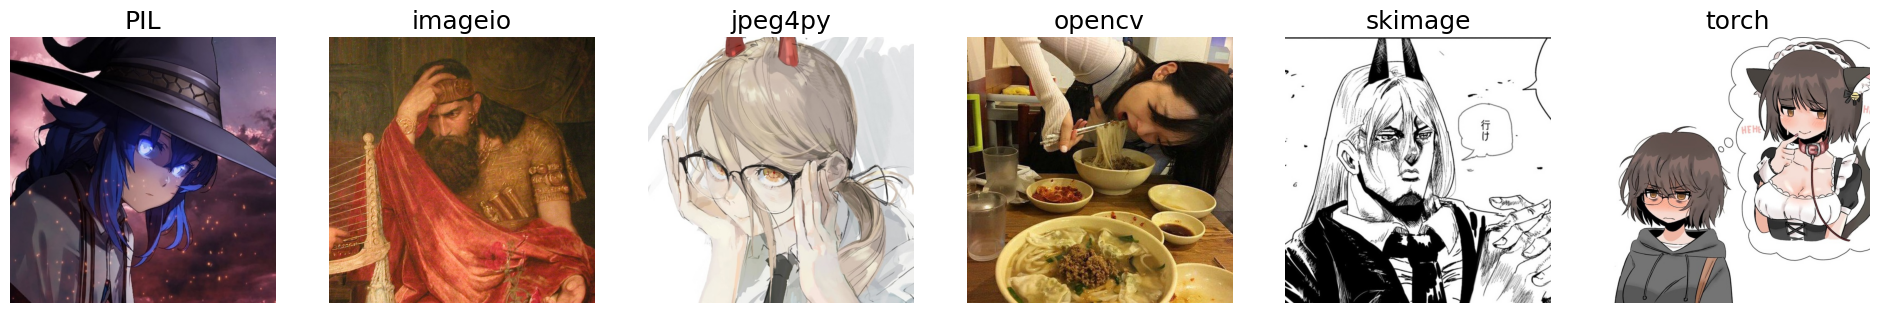

In [12]:
class GetArray:
    def PIL(self, image_path: str) -> np.array:
        img = Image.open(image_path)
        img = img.convert("RGB")
        return np.asarray(img)

    def opencv(self, image_path: str) -> np.array:
        img = cv2.imread(image_path)
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    def jpeg4py(self, image_path: str) -> np.array:
        return jpeg4py.JPEG(image_path).decode()

    def skimage(self, image_path: str) -> np.array:
        return skimage.io.imread(image_path, plugin="matplotlib")

    def imageio(self, image_path: str) -> np.array:
        return imageio.v2.imread(image_path)

    def torch(self, image_path: str) -> np.array:
        return read_image(image_path)


array_getter = GetArray()
methods_pool = inspect.getmembers(array_getter, predicate=inspect.ismethod)
print("Methods pool: ", [method_name for method_name, method in methods_pool], "\n")

fig, axs = plt.subplots(1, 6, figsize=(24, 6))

for i, ax in enumerate(axs):
    ax.axis("off")
    ax.imshow(methods_pool[i][1](f"pics/1/{i + 1}.jpg"))
    ax.set_title(methods_pool[i][0], fontsize=18)

Now, examine `image_loaders_benchmark.py` code, which runs image decoding with the frameworks above 2000 times and check time consumption of each algorithm.

Run `python3 image_loaders_benchmark.py -d pics/1`.

## 4. Data augmentations on GPU: Nvidia DALI

Nvidia DALI allows to move CPU workload to GPU in some cases, which include but are not limited to data loading and data preprocessing. This might be useful if you have a CPU bottleneck in your setup.

Check out documentation [page](https://docs.nvidia.com/deeplearning/dali/user-guide/docs/index.html) and [guideline](https://docs.nvidia.com/deeplearning/dali/user-guide/docs/examples/use_cases/pytorch/resnet50/pytorch-resnet50.html) for conv nets training on ImageNet with DALI. Source code from guideline: [here](https://github.com/NVIDIA/DALI/blob/c572c3f98a1cfccdcca37ba4e4538419913e54fd/docs/examples/use_cases/pytorch/resnet50/main.py).

For this seminar let's borrow augmentations demo from docs.

In [ ]:
# !curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash
# ! sudo apt install git-lfs
# !git install lfs
# ! git clone git@github.com:NVIDIA/DALI_extra.git

In [1]:
import math
import os.path

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import nvidia.dali.fn as fn
import nvidia.dali.types as types
from nvidia.dali import pipeline_def

test_data_root = "DALI_extra"
db_folder = os.path.join(test_data_root, "db", "lmdb")

In [5]:
augmentations = dict()

# input is sampled randomly for output pixel's neighbourhood
augmentations["erase"] = lambda images: fn.erase(
    images,
    anchor=[0.3, 0.2],
    shape=[0.5, 0.6],
    normalized_anchor=True,
    normalized_shape=True,
    axis_names="HW",
)
augmentations["slice"] = lambda images: fn.slice(
    images, rel_start=[0.3, 0.2], rel_shape=[0.5, 0.6], axis_names="HW"
)
# transforms sampling coordinates to produce wavy patterns
augmentations["water"] = lambda images: fn.water(images)
# applies fisheye distortion
augmentations["sphere"] = lambda images: fn.sphere(images)
# rotates the image, enlarging the canvas
augmentations["rotate"] = lambda images: fn.rotate(
    images, angle=30, interp_type=types.INTERP_LINEAR, fill_value=0
)
# applies affine transform
augmentations["warp_affine"] = lambda images: fn.warp_affine(
    images, matrix=[1.0, 0.8, 0.0, 0.0, 1.2, 0.0], interp_type=types.INTERP_LINEAR
)
# manipulates brightness and contrast of the image
augmentations["brightness_contrast"] = lambda images: fn.brightness_contrast(
    images, brightness=0.5, contrast=1.5
)
# Generate JPEG compression artifacts
augmentations[
    "jpeg compression distortion"
] = lambda images: fn.jpeg_compression_distortion(images, quality=5)
# twists colors of the image
augmentations["hsv"] = lambda images: fn.hsv(images, hue=45.0, saturation=0.2)
# places the image on a larger canvas
augmentations["paste"] = lambda images: fn.paste(
    images, ratio=2.0, fill_value=(55, 155, 155), paste_x=0.1, paste_y=0.7
)
# param flips the image
augmentations["vertical and horizontal flip"] = lambda images: fn.flip(
    images, vertical=1, horizontal=1
)

In [6]:
@pipeline_def()
def augmentation_gallery_pipe(path):
    encoded, labels = fn.readers.caffe(path=path, random_shuffle=True)
    images = fn.decoders.image(encoded, device="mixed", output_type=types.RGB)
    return tuple([labels, images] + [aug(images) for aug in augmentations.values()])


pipe = augmentation_gallery_pipe(
    path=db_folder, batch_size=32, num_threads=2, device_id=0, seed=10
)
pipe.build()

Examine your GPU load with `nvidia-smi` while running next cell.

In [7]:
pipe_out = pipe.run()

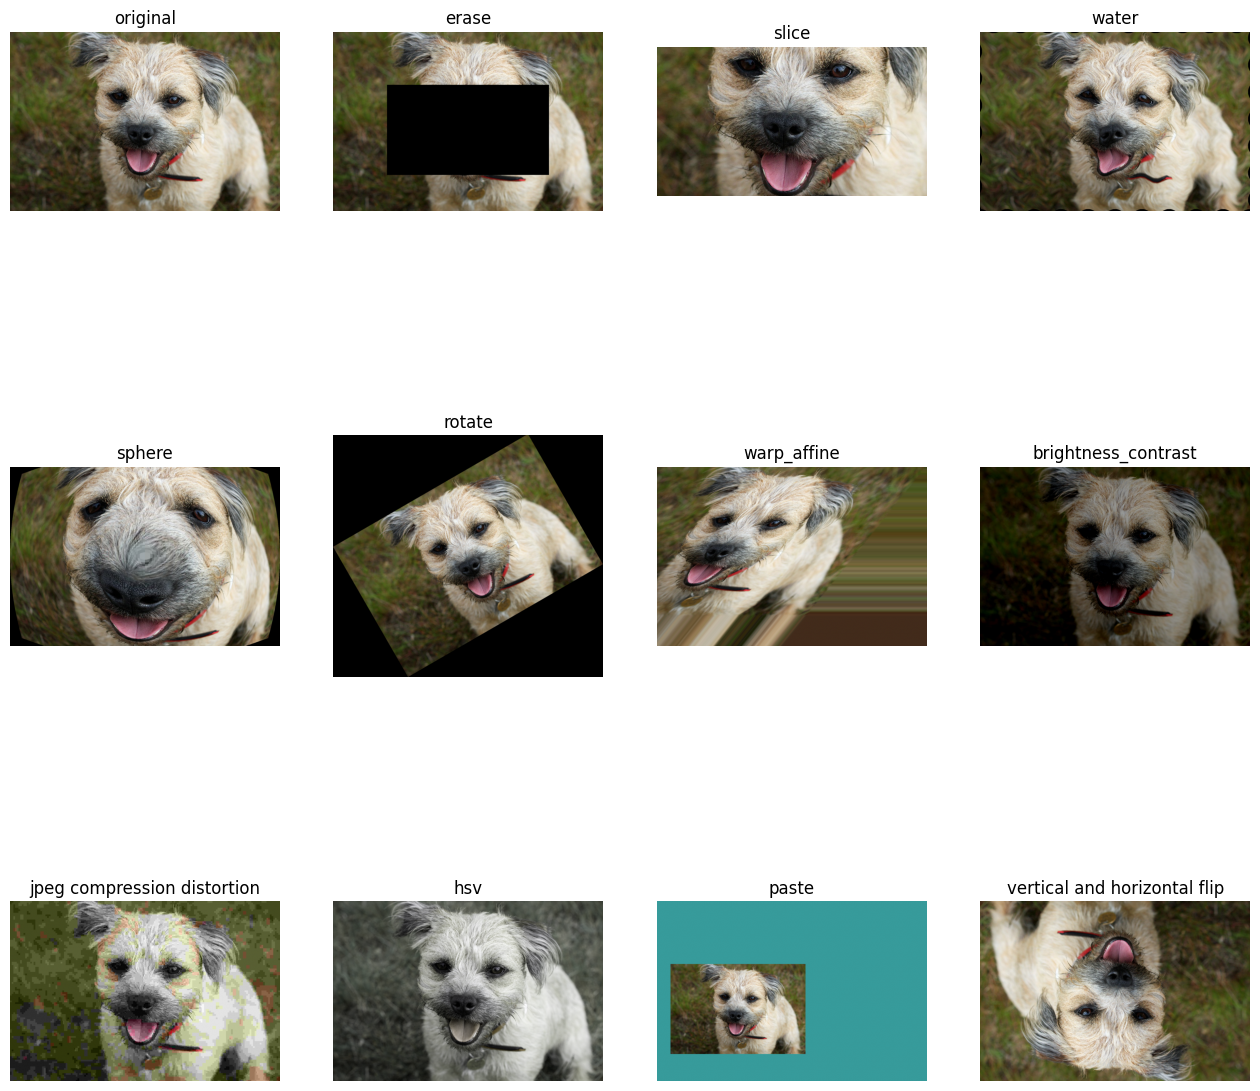

In [8]:
n = 5
len_outputs = len(pipe_out) - 1
augmentations = ["original"] + list(augmentations.keys())
fig = plt.figure(figsize=(16, 16))
columns = 4
rows = int(math.ceil(len_outputs / columns))
gs = gridspec.GridSpec(rows, columns)
for i in range(len_outputs):
    plt.subplot(gs[i])
    plt.axis("off")
    plt.title(augmentations[i])
    pipe_out_cpu = pipe_out[1 + i].as_cpu()
    img_chw = pipe_out_cpu.at(n)
    plt.imshow(img_chw / 255.0)

## 5. Data loading to GPU: efficient batching for LM

Let's recall that working with data in Pytorch is usually divided into two different entities: `torch.utils.data.Dataset` and `torch.utils.data.Dataloader`. In the class, inherited from `torch.utils.data.Dataset` you must implement three methods: `__init__` and `__getitem__` (obligatory) and `__len__` (preferably but not obligatory). However, it's `torch.utils.data.Dataloader`, which spawns different CPU workers which call dataset's `__getitem__` and combine batches for training.

Standard batching approach (default `collate_fn`) is just to stack tensors acquired with `__getitem__`. But sometimes it is not enough because we might need additional operations to be made with each element of the batch. The examples of such scenarios are:

- Sequences with varying length
- Different labels dimensions
- Other batch-level preprocessing steps

In [9]:
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

**BRAIN**: pad everything to a fixed `max_length`.

**BIG BRAIN (THIS SECTION)**: pad only in the `collate_fn`.

**ULTRA BIG BRAIN (HOMEWORK)**: presort data to sample sequences smartly, preserving similar examples length in the batch.

**ULTRA DUPER BIG BRAIN (HOMEWORK)**: pack all sequences into one long sequence and generate metadata that indicates where each original sequence starts and ends. This minimizes padding and improves comutational efficiency by maximizing the use of available space.

In [14]:
lines = [
    "One thing I don't know why",
    "It doesn't even matter how hard you try",
    "Keep that in mind, I designed this rhyme",
    "To explain in due time",
    "All I know",
    "Time is a valuable thing",
    "Watch it fly by as the pendulum swings",
    "Watch it count down to the end of the day",
    "The clock ticks life away",
    "It's so unreal",
    "Didn't look out below",
    "Watch the time go right out the window",
    "Tryin' to hold on, did-didn't even know",
    "I wasted it all just to watch you go",
    "I kept everything inside and even though I tried",
    "It all fell apart",
    "What it meant to me will eventually",
    "Be a memory of a time when I tried so hard",
    "I tried so hard and got so far",
    "But in the end it doesn't even matter",
    "I had to fall to lose it all",
    "But in the end it doesn't even matter",
]
labels = torch.randint(2, (len(lines),))
dataset = list(zip(lines, labels))
tokenizer = get_tokenizer("basic_english")


def yield_tokens(data_iter):
    for text, label in data_iter:
        yield tokenizer(text)


vocab = build_vocab_from_iterator(yield_tokens(iter(dataset)), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

text_pipeline = lambda x: vocab(tokenizer(x))


def collate_batch(
    batch: list[tuple[str, torch.Tensor]]
) -> tuple[torch.Tensor, torch.Tensor]:
    text_list, label_list = [], []
    for _text, _label in batch:
        label_list.append(_label)
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)

    text_list = nn.utils.rnn.pad_sequence(text_list, batch_first=True, padding_value=0)
    label_list = torch.tensor(label_list, dtype=torch.int64)

    return text_list, label_list


dataloader = DataLoader(dataset, batch_size=2, collate_fn=collate_batch, shuffle=True)

for x, _ in dataloader:
    print(f"Current batch:\n{x}\n")

Current batch:
tensor([[ 2, 58, 44, 54, 21,  7, 75,  2, 19,  0],
        [22,  9,  4, 15,  1, 14,  3,  6,  7, 18]])

Current batch:
tensor([[ 2, 51,  5, 46,  5, 61,  1,  8,  0,  0],
        [ 1, 14,  3,  6,  7, 18, 53, 16, 27, 77]])

Current batch:
tensor([[11, 55, 13, 80, 26],
        [ 1,  3, 71, 10, 79]])

Current batch:
tensor([[ 2, 81,  1,  8, 56,  5, 12, 27, 23],
        [67, 26,  2, 40,  3,  6, 17, 84,  0]])

Current batch:
tensor([[57, 73,  9, 65, 20,  2, 37, 74, 69,  0,  0],
        [78,  3,  5, 52, 66, 20, 38,  3,  6,  7, 17]])

Current batch:
tensor([[82,  1, 63,  5, 62, 85, 43,  0],
        [ 2, 19, 10, 16, 21, 50, 10, 47]])

Current batch:
tensor([[22,  9,  4, 15,  1, 14,  3,  6,  7, 18],
        [12,  1, 49, 33, 29,  4, 68, 72,  0,  0]])

Current batch:
tensor([[31, 13, 64, 24, 13, 11, 83,  2, 19, 10, 16],
        [ 8,  2, 17,  0,  0,  0,  0,  0,  0,  0,  0]])

Current batch:
tensor([[ 4, 34, 76, 59, 30,  0,  0,  0],
        [12,  4, 11, 23, 70, 25,  4, 86]])

Current bat

Also check out [docs](https://huggingface.co/docs/transformers/main_classes/data_collator) for `transformers.DataCollatorWithPadding`.